# Ethical Zeta Function and Zero Distribution

This notebook explores the "ethical zeta function" ζ_E(s) and its zeros.

In analogy with the Riemann zeta function:
- ζ(s) has zeros that encode information about primes
- ζ_E(s) has zeros that encode information about ethical primes

The Riemann Hypothesis states all non-trivial zeros have Re(s) = 1/2.
We check if ethical zeta zeros cluster near a critical line.


In [1]:
import sys
import os
from pathlib import Path

# Robust path setup
def setup_paths():
    current_dir = Path(os.getcwd())
    if current_dir.name == 'notebooks':
        simulation_dir = str(current_dir.parent)
        if simulation_dir not in sys.path:
            sys.path.insert(0, simulation_dir)
        return simulation_dir
    elif current_dir.name == 'simulation':
        simulation_dir = str(current_dir)
        if simulation_dir not in sys.path:
            sys.path.insert(0, simulation_dir)
        return simulation_dir
    for parent in current_dir.parents:
        if parent.name == 'simulation':
            simulation_dir = str(parent)
            if simulation_dir not in sys.path:
                sys.path.insert(0, simulation_dir)
            return simulation_dir
    for path in ['..', '../simulation', 'simulation']:
        abs_path = os.path.abspath(path)
        if abs_path not in sys.path:
            sys.path.insert(0, abs_path)
    return None

setup_paths()

import numpy as np
import matplotlib.pyplot as plt
try:
    import ipywidgets as widgets
    from IPython.display import display
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False

from core.action_space import generate_world
from core.judgement_system import BiasedJudge, NoisyJudge, ConservativeJudge, evaluate_judgement
from core.ethical_primes import select_ethical_primes
from analysis.zeta_function import build_m_sequence, find_approximate_zeros, compute_spectrum, analyze_spectrum_peaks
from visualization.plots import setup_paper_style, plot_zero_distribution, plot_spectrum

setup_paper_style()
np.random.seed(42)


## Configuration

Set parameters for zero finding and spectrum analysis.


In [2]:
# Configuration
num_actions = 1000
tau = 0.3
X_max = 200
real_range = (0.3, 0.7)
imag_range = (0, 30)
grid_size = 40

if WIDGETS_AVAILABLE:
    real_min_widget = widgets.FloatSlider(value=0.3, min=0.0, max=1.0, step=0.05, description='Re min:')
    real_max_widget = widgets.FloatSlider(value=0.7, min=0.0, max=1.0, step=0.05, description='Re max:')
    imag_max_widget = widgets.IntSlider(value=30, min=10, max=100, step=5, description='Im max:')
    grid_widget = widgets.IntSlider(value=40, min=20, max=100, step=10, description='Grid size:')
    
    def update_params(re_min, re_max, im_max, grid):
        global real_range, imag_range, grid_size
        real_range = (re_min, re_max)
        imag_range = (0, im_max)
        grid_size = grid
        print(f"Updated: real_range={real_range}, imag_range={imag_range}, grid_size={grid_size}")
    
    interact = widgets.interactive(update_params, 
                                  re_min=real_min_widget, re_max=real_max_widget,
                                  im_max=imag_max_widget, grid=grid_widget)
    display(interact)
else:
    print(f"Using fixed parameters: real_range={real_range}, imag_range={imag_range}, grid_size={grid_size}")


interactive(children=(FloatSlider(value=0.3, description='Re min:', max=1.0, step=0.05), FloatSlider(value=0.7…

## Generate Data and Find Zeros (Single Judge)


Generated 1000 actions
Found 11 ethical primes
Built m sequence of length 200

Found 0 approximate zeros in range Re(s) ∈ (0.3, 0.7), Im(s) ∈ (0, 30)


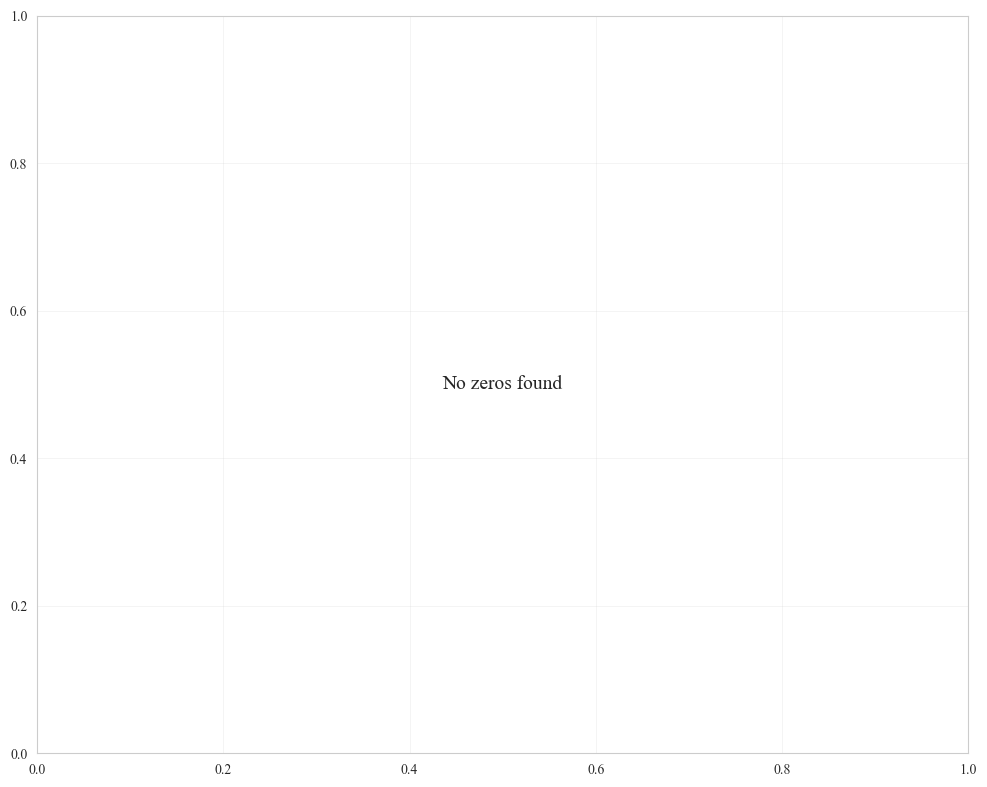

In [3]:
# Generate and evaluate with BiasedJudge
actions = generate_world(num_actions=num_actions, random_seed=42)
judge = BiasedJudge(bias_strength=0.2)
evaluate_judgement(actions, judge, tau=tau)
primes = select_ethical_primes(actions)

print(f"Generated {num_actions} actions")
print(f"Found {len(primes)} ethical primes")

# Build m sequence
m = build_m_sequence(primes, X_max=X_max, mode='count')
print(f"Built m sequence of length {len(m)}")

# Find zeros
zeros = find_approximate_zeros(m, real_range=real_range, imag_range=imag_range, grid_size=grid_size)
print(f"\nFound {len(zeros)} approximate zeros in range Re(s) ∈ {real_range}, Im(s) ∈ {imag_range}")

# Plot zero distribution
plot_zero_distribution(zeros, save_path='../output/figures/03_zeros.pdf')
plt.show()


## Critical Line Analysis

Analyze how close zeros are to the critical line Re(s) = 1/2 (analogous to the Riemann Hypothesis).


In [4]:
# Critical line analysis
critical_line = 0.5
if len(zeros) > 0:
    real_parts = [z.real for z in zeros]
    imag_parts = [z.imag for z in zeros]
    distances = [abs(r - critical_line) for r in real_parts]
    
    print("Critical Line Analysis:")
    print("=" * 60)
    print(f"Critical line: Re(s) = {critical_line}")
    print(f"Mean distance from critical line: {np.mean(distances):.4f}")
    print(f"Median distance: {np.median(distances):.4f}")
    print(f"Min distance: {np.min(distances):.4f}")
    print(f"Max distance: {np.max(distances):.4f}")
    print(f"Zeros within 0.1 of critical line: {sum(1 for d in distances if d < 0.1)}/{len(zeros)}")
    
    # Plot distance distribution
    plt.figure(figsize=(10, 6))
    plt.hist(distances, bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(np.mean(distances), color='r', linestyle='--', label=f'Mean: {np.mean(distances):.3f}')
    plt.xlabel('Distance from Critical Line |Re(s) - 0.5|')
    plt.ylabel('Frequency')
    plt.title('Distribution of Zero Distances from Critical Line')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../output/figures/03_critical_line_distances.pdf', dpi=300)
    plt.show()
    
    # Zero density analysis
    print(f"\nZero Density Analysis:")
    print(f"Zeros per unit area: {len(zeros) / ((real_range[1] - real_range[0]) * (imag_range[1] - imag_range[0])):.2f}")
else:
    print("No zeros found for analysis")


No zeros found for analysis


## Spectrum Analysis

Analyze the frequency spectrum of the ethical zeta function.


In [5]:
# Spectrum analysis
freqs, amps = compute_spectrum(m)
peaks = analyze_spectrum_peaks(freqs, amps, num_peaks=5)

print("Spectrum Analysis:")
print("=" * 60)
print(f"Frequency range: [{freqs[0]:.4f}, {freqs[-1]:.4f}]")
print(f"Number of frequency bins: {len(freqs)}")
print(f"\nTop {len(peaks)} peaks:")
for i, (freq, amp) in enumerate(peaks, 1):
    print(f"  {i}. Frequency: {freq:.4f}, Amplitude: {amp:.4f}")

# Plot spectrum
plot_spectrum(freqs, amps, peaks, save_path='../output/figures/03_spectrum.pdf')
plt.show()


Spectrum Analysis:
Frequency range: [0.0000, 0.4950]
Number of frequency bins: 100

Top 5 peaks:


ValueError: too many values to unpack (expected 2, got 3)

## Multi-Judge Comparison

Compare zeros and spectra across different judgment systems.


In [ ]:
# Compare multiple judges
judges_to_compare = {
    'Biased': BiasedJudge(bias_strength=0.2),
    'Noisy': NoisyJudge(noise_scale=0.3),
    'Conservative': ConservativeJudge(threshold=0.5)
}

all_zeros = {}
all_spectra = {}

for judge_name, judge in judges_to_compare.items():
    # Generate fresh actions for each judge
    actions_comp = generate_world(num_actions=num_actions, random_seed=42)
    evaluate_judgement(actions_comp, judge, tau=tau)
    primes_comp = select_ethical_primes(actions_comp)
    
    # Build sequence and find zeros
    m_comp = build_m_sequence(primes_comp, X_max=X_max, mode='count')
    zeros_comp = find_approximate_zeros(m_comp, real_range=real_range, imag_range=imag_range, grid_size=grid_size)
    all_zeros[judge_name] = zeros_comp
    
    # Compute spectrum
    freqs_comp, amps_comp = compute_spectrum(m_comp)
    all_spectra[judge_name] = (freqs_comp, amps_comp)
    
    print(f"{judge_name:15s}: {len(zeros_comp)} zeros, spectrum range: [{freqs_comp[0]:.3f}, {freqs_comp[-1]:.3f}]")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Zero distribution comparison
ax1 = axes[0]
for judge_name, zeros_comp in all_zeros.items():
    if len(zeros_comp) > 0:
        real_parts = [z.real for z in zeros_comp]
        imag_parts = [z.imag for z in zeros_comp]
        ax1.scatter(real_parts, imag_parts, label=judge_name, alpha=0.6, s=30)

ax1.axvline(0.5, color='r', linestyle='--', linewidth=2, label='Critical Line Re(s)=0.5')
ax1.set_xlabel('Re(s)')
ax1.set_ylabel('Im(s)')
ax1.set_title('Zero Distribution Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Spectrum comparison
ax2 = axes[1]
for judge_name, (freqs_comp, amps_comp) in all_spectra.items():
    ax2.plot(freqs_comp, amps_comp, label=judge_name, alpha=0.7, linewidth=2)

ax2.set_xlabel('Frequency')
ax2.set_ylabel('Amplitude')
ax2.set_title('Spectrum Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig('../output/figures/03_multi_judge_comparison.pdf', dpi=300)
plt.show()


## Export Results

Save zero coordinates and spectrum data for further analysis.


In [ ]:
# Export zeros
os.makedirs('../output', exist_ok=True)

# Save zero coordinates
import json
zeros_data = {
    'Biased': [[z.real, z.imag] for z in zeros],
    'metadata': {
        'real_range': real_range,
        'imag_range': imag_range,
        'grid_size': grid_size,
        'num_primes': len(primes)
    }
}

# Add other judges (if multi-judge comparison was run)
if 'all_zeros' in globals() and all_zeros:
    for judge_name, zeros_comp in all_zeros.items():
        if judge_name != 'Biased':
            zeros_data[judge_name] = [[z.real, z.imag] for z in zeros_comp]

with open('../output/zeros_data.json', 'w') as f:
    json.dump(zeros_data, f, indent=2)

print("Exported zero coordinates to: ../output/zeros_data.json")

# Export spectrum data
spectrum_data = {}
# Add Biased judge spectrum
freqs, amps = compute_spectrum(m)
spectrum_data['Biased'] = {
    'frequencies': freqs.tolist(),
    'amplitudes': amps.tolist()
}

# Add other judges (if multi-judge comparison was run)
if 'all_spectra' in globals() and all_spectra:
    for judge_name, (freqs_comp, amps_comp) in all_spectra.items():
        if judge_name != 'Biased':
            spectrum_data[judge_name] = {
                'frequencies': freqs_comp.tolist(),
                'amplitudes': amps_comp.tolist()
            }

with open('../output/spectrum_data.json', 'w') as f:
    json.dump(spectrum_data, f, indent=2)

print("Exported spectrum data to: ../output/spectrum_data.json")
